In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.linear_model import RidgeCV, LassoCV
from sklearn.ensemble import RandomForestRegressor

SyntaxError: invalid syntax (3922139294.py, line 1)

In [ ]:
df_films = pd.read_csv(r"C:\Users\user\Desktop\Data Analysis\Film Data Analytics Project\data\raw\films.csv")
df_characters = pd.read_csv(r"C:\Users\user\Desktop\Data Analysis\Film Data Analytics Project\data\raw\characters.csv")
df_crew_members = pd.read_csv(r"C:\Users\user\Desktop\Data Analysis\Film Data Analytics Project\data\raw\crew_members.csv")
df_soundtracks = pd.read_csv(r"C:\Users\user\Desktop\Data Analysis\Film Data Analytics Project\data\raw\soundtracks.csv")
df_settings_and_world = pd.read_csv(r"C:\Users\user\Desktop\Data Analysis\Film Data Analytics Project\data\raw\settings_and_world.csv")
df_animation_settings = pd.read_csv(r"C:\Users\user\Desktop\Data Analysis\Film Data Analytics Project\data\raw\animation_settings.csv")
df_symbolism_and_motifs = pd.read_csv(r"C:\Users\user\Desktop\Data Analysis\Film Data Analytics Project\data\raw\symbolism_and_motifs.csv")
df_release_info = pd.read_csv(r"C:\Users\user\Desktop\Data Analysis\Film Data Analytics Project\data\raw\release_info.csv")
df_sociopolitical = pd.read_csv(r"C:\Users\user\Desktop\Data Analysis\Film Data Analytics Project\data\raw\sociopolitical.csv")
df_rating = pd.read_csv(r"C:\Users\user\Desktop\Data Analysis\Film Data Analytics Project\data\raw\rating.csv")
df_cultural_info = pd.read_csv(r"C:\Users\user\Desktop\Data Analysis\Film Data Analytics Project\data\raw\cultural_info.csv")
df_parents_guide = pd.read_csv(r"C:\Users\user\Desktop\Data Analysis\Film Data Analytics Project\data\raw\parents_guide.csv")
df_franchise = pd.read_csv(r"C:\Users\user\Desktop\Data Analysis\Film Data Analytics Project\data\raw\franchise.csv")
df_story_and_themes = pd.read_csv(r"C:\Users\user\Desktop\Data Analysis\Film Data Analytics Project\data\raw\story_and_themes.csv")

In [ ]:

def mode_safe(s):
    try:
        m = s.mode(dropna=True)
        return m.iloc[0] if len(m) else np.nan
    except Exception:
        return np.nan

def to_bool01(s):
    return (
        s.astype(str).str.lower()
         .map({'1':1,'true':1,'yes':1,'y':1,'evet':1,'t':1,'nan':np.nan,'none':np.nan})
         .fillna(0).astype(int)
    )

df_films = df_films.drop_duplicates(subset=['film_id'])

tmp = df_characters.copy()
if 'is_protagonist' in tmp.columns:
    tmp['is_protagonist_01'] = to_bool01(tmp['is_protagonist'])
char_agg = tmp.groupby('film_id').agg(
    n_characters      = ('char_id','count'),
    protagonist_cnt   = ('is_protagonist_01','sum'),
    screen_time_mean  = ('screen_time_ratio','mean'),
    screen_time_max   = ('screen_time_ratio','max'),
    top_gender        = ('char_gender', mode_safe),
    top_role_type     = ('role_type', mode_safe),
    top_performance   = ('performance_type', mode_safe),
).reset_index()

crew = df_crew_members.copy()
crew['is_director'] = (crew['job_title'].str.lower().str.contains('director', na=False)).astype(int)
crew['is_writer']   = (crew['job_title'].str.lower().str.contains('writer',   na=False)).astype(int)
crew_agg = crew.groupby('film_id').agg(
    crew_count   = ('crew_id','count'),
    has_director = ('is_director','max'),
    has_writer   = ('is_writer','max'),
).reset_index()

dept_cnt = (crew.pivot_table(index='film_id', columns='department', values='crew_id', aggfunc='count', fill_value=0)
                 .add_prefix('dept_').reset_index())

snd = df_soundtracks.copy()
for c in ['is_main_theme','vocal_presence','diegetic','award_won']:
    if c in snd.columns:
        snd[c+'_01'] = to_bool01(snd[c])
snd['n_music_genres'] = snd['music_genres'].fillna('').apply(lambda x: len(set([t.strip() for t in x.split(',') if t.strip()])))

snd_agg = snd.groupby('film_id').agg(
    n_tracks            = ('soundtrack_id','count'),
    any_main_theme      = ('is_main_theme_01','max'),
    any_vocal           = ('vocal_presence_01','max'),
    any_diegetic        = ('diegetic_01','max'),
    soundtrack_int_mean = ('track_emotional_intensity','mean'),
    music_genre_divers  = ('n_music_genres','max'),
    any_music_award     = ('award_won_01','max') if 'award_won_01' in snd.columns else ('soundtrack_id','size')
).reset_index()

def dedup_11(df, cols):
    return df.drop_duplicates(subset=['film_id'])[ ['film_id'] + cols ]

rating_cols = ['audience_rating_mean','critic_rating_mean','rating_gap','social_sentiment_score']
socio_cols  = ['political_content_present','activism_message_strength','controversy_level','environmental_theme_present']
symb_cols   = ['symbolism_density','visual_metaphor_strength','religious_symbolism_present','death_symbolism_present']
cult_cols   = ['slang_intensity','accent_comedy_used','language_switching','translation_difficulty_score']
pg_cols     = ['family_friendly_score','violence_intensity','sexual_content_intensity','age_recommendation']
fr_cols     = ['is_sequel','franchise_total_films','franchise_avg_rating']
rel_cols    = ['release_month','release_season','holiday_release','theatrical_vs_digital']
story_cols  = ['main_theme','has_major_twist','narrative_complexity','based_on_true_story','tone','stakes_level']

df_rating = dedup_11(df_rating, rating_cols)
df_socio  = dedup_11(df_sociopolitical, socio_cols)
df_symb   = dedup_11(df_symbolism_and_motifs, symb_cols)
df_cult   = dedup_11(df_cultural_info, cult_cols)
df_pg     = dedup_11(df_parents_guide, pg_cols)
df_fr     = dedup_11(df_franchise, fr_cols)
df_rel    = dedup_11(df_release_info, rel_cols)
df_story  = dedup_11(df_story_and_themes, story_cols)

df_main = (
    df_films
      .merge(df_rating, on='film_id', how='left')
      .merge(df_socio,  on='film_id', how='left')
      .merge(df_symb,   on='film_id', how='left')
      .merge(df_cult,   on='film_id', how='left')
      .merge(df_pg,     on='film_id', how='left')
      .merge(df_fr,     on='film_id', how='left')
      .merge(df_rel,    on='film_id', how='left')
      .merge(df_story,  on='film_id', how='left')
      .merge(char_agg,  on='film_id', how='left')
      .merge(crew_agg,  on='film_id', how='left')
      .merge(dept_cnt,  on='film_id', how='left')
      .merge(snd_agg,   on='film_id', how='left')
)

print(df_main.shape)
df_main.head()


(500, 73)


,film_id,film_name,release_year,genre,film_duration,film_country,film_language,film_budget,film_box_office,film_votes_count,...,dept_Sound,dept_VisualEffects,dept_Writing,n_tracks,any_main_theme,any_vocal,any_diegetic,soundtrack_int_mean,music_genre_divers,any_music_award
0,1,Avatar,2009,Action|Adventure|Sci-Fi,162,USA,en,237000000,2923706026,13000000,...,1,1,1,3.0,1.0,1.0,0.0,0.850000,1.0,1.0
1,2,Avengers: Endgame,2019,Action|Adventure|Sci-Fi,181,USA,en,356000000,2797501328,12000000,...,1,1,2,3.0,1.0,0.0,0.0,0.900000,1.0,1.0
2,3,Avatar: The Way of Water,2022,Action|Adventure|Sci-Fi,192,USA,en,350000000,2320287321,9000000,...,1,1,1,3.0,1.0,0.0,0.0,0.800000,1.0,0.0
3,4,Titanic,1997,Drama|Romance,195,USA,en,200000000,2264645982,13000000,...,1,1,1,3.0,1.0,1.0,0.0,0.850000,1.0,1.0
4,5,Star Wars Ep. VII: The Force Awakens,2015,Action|Adventure|Sci-Fi,138,USA,en,245000000,2071310218,9500000,...,1,0,2,3.0,1.0,0.0,0.0,0.883333,1.0,0.0


In [ ]:
selected_columns = [
    'film_budget','film_duration','film_country','film_language',
    'film_awards_count','genre','studio_name',
    'audience_rating_mean','critic_rating_mean','rating_gap',
    'symbolism_density','visual_metaphor_strength',
    'slang_intensity','family_friendly_score','violence_intensity',
    'is_sequel','franchise_total_films','release_season',
    'holiday_release','activism_message_strength','controversy_level',
    'main_theme','narrative_complexity','film_box_office'
]
df_model = df_main[[c for c in selected_columns if c in df_main.columns]].copy()

print(df_model.shape)
df_model.head()


(500, 24)


,film_budget,film_duration,film_country,film_language,film_awards_count,genre,studio_name,audience_rating_mean,critic_rating_mean,rating_gap,...,violence_intensity,is_sequel,franchise_total_films,release_season,holiday_release,activism_message_strength,controversy_level,main_theme,narrative_complexity,film_box_office
0,237000000,162,USA,en,3,Action|Adventure|Sci-Fi,20th Century Fox,8.2,7.8,0.4,...,0.6,False,NaN,Winter,FALSE,0.8,0.3,survival,0.70,2923706026
1,356000000,181,USA,en,6,Action|Adventure|Sci-Fi,Marvel Studios,8.4,8.1,0.3,...,0.6,True,33.0,Spring,FALSE,0.2,0.2,sacrifice,0.85,2797501328
2,350000000,192,USA,en,4,Action|Adventure|Sci-Fi,20th Century Studios,7.8,7.6,0.2,...,0.5,True,5.0,Winter,TRUE,0.7,0.2,family,0.65,2320287321
3,200000000,195,USA,en,11,Drama|Romance,Paramount Pictures,8.1,7.8,0.3,...,0.3,False,NaN,Winter,FALSE,0.3,0.1,love,0.60,2264645982
4,245000000,138,USA,en,5,Action|Adventure|Sci-Fi,Walt Disney Pictures,7.3,8.1,-0.8,...,0.5,True,12.0,Winter,FALSE,0.5,0.3,coming_of_age,0.70,2071310218


In [ ]:
num_cols = df_model.select_dtypes(include=['int64', 'float64']).columns
print("numerical:", list(num_cols))
num_cols = [c for c in num_cols if c != 'film_box_office']



numerical: ['film_budget', 'film_duration', 'film_awards_count', 'audience_rating_mean', 'critic_rating_mean', 'rating_gap', 'symbolism_density', 'visual_metaphor_strength', 'slang_intensity', 'family_friendly_score', 'violence_intensity', 'franchise_total_films', 'activism_message_strength', 'controversy_level', 'narrative_complexity', 'film_box_office']


In [ ]:
skew_vals = df_model[num_cols].skew().sort_values(ascending=False)
symmetric_cols = skew_vals[skew_vals.abs() < 1].index.tolist()
skewed_cols = skew_vals[skew_vals.abs() >= 1].index.tolist()

exclude_film_box_office = {'film_box_office'}
symmetric_cols = [c for c in symmetric_cols if c in df_model.columns and c not in exclude_film_box_office]
skewed_cols    = [c for c in skewed_cols    if c in df_model.columns and c not in exclude_film_box_office]

mean_fill   = df_model[symmetric_cols].mean(numeric_only=True)
median_fill = df_model[skewed_cols].median(numeric_only=True)

df_model[symmetric_cols] = df_model[symmetric_cols].fillna(mean_fill)
df_model[skewed_cols]    = df_model[skewed_cols].fillna(median_fill)

na_after = df_model[symmetric_cols + skewed_cols].isna().sum().sort_values(ascending=False)
print(na_after)

activism_message_strength    0
film_duration                0
film_budget                  0
narrative_complexity         0
violence_intensity           0
family_friendly_score        0
audience_rating_mean         0
critic_rating_mean           0
visual_metaphor_strength     0
symbolism_density            0
film_awards_count            0
slang_intensity              0
franchise_total_films        0
controversy_level            0
rating_gap                   0
dtype: int64


In [ ]:
# 1) Boolean benzeri kolonları 0/1 yap
bool_cols = ['holiday_release','is_sequel','accent_comedy_used','language_switching',
             'cultural_instrument_usage','sexual_content_present']  # sende hangileri varsa
for c in bool_cols:
    if c in df_model.columns:
        df_model[c] = (df_model[c].astype(str).str.lower()
                       .map({'true':1,'1':1,'yes':1,'evet':1,
                             'false':0,'0':0,'no':0,'hayır':0})
                       .fillna(0).astype(int))

# 2) Kategorik kolonlar: nadir kategorileri "Other" yap (örn. frekans < %1)
cat_cols = ['film_country','film_language','genre','studio_name','release_season','main_theme']
for c in [x for x in cat_cols if x in df_model.columns]:
    vc = df_model[c].value_counts(normalize=True, dropna=False)
    rare = vc[vc < 0.01].index
    df_model[c] = df_model[c].where(~df_model[c].isin(rare), other='Other')

# 3) Tipleri netleştir
for c in [x for x in cat_cols if x in df_model.columns]:
    df_model[c] = df_model[c].astype('category')

# 4) Son kontrol: object kaldı mı?
left_obj = df_model.select_dtypes(include=['object']).columns.tolist()
print("OBJECT kalanlar:", left_obj)  # boş olmalı veya sadece encode edilecek kategoriler olmalı





OBJECT kalanlar: []


In [ ]:
X = df_model.drop(columns=['film_box_office'])
y = df_model['film_box_office']

num_cols = X.select_dtypes(include=['int64','float64']).columns.tolist()
cat_cols = X.select_dtypes(include=['category']).columns.tolist()

pre = ColumnTransformer([
    ('num', Pipeline([('imp', SimpleImputer(strategy='median')),
                      ('sc', StandardScaler())]), num_cols),
    ('cat', Pipeline([('imp', SimpleImputer(strategy='most_frequent')),
                      ('ohe', OneHotEncoder(drop='first', handle_unknown='ignore'))]), cat_cols)
])

X_tr, X_te, y_tr, y_te = train_test_split(X, y, test_size=0.2, random_state=42)

pipe = Pipeline([('prep', pre), ('model', LinearRegression())])
pipe.fit(X_tr, y_tr)

Pipeline(steps=[('prep',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imp',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('sc',
                                                                   StandardScaler())]),
                                                  ['film_budget',
                                                   'film_duration',
                                                   'film_awards_count',
                                                   'audience_rating_mean',
                                                   'critic_rating_mean',
                                                   'rating_gap',
                                                   'symbolism_density',
                                                   'visual_metaphor_strength',
                                                   'slang_intensity',
                                                   'family_friendly_score',
                                                   'violen...
                                                   'franchise_total_films',
                                                   'holiday_release',
                                                   'activism_message_strength',
                                                   'controversy_level',
                                                   'narrative_complexity']),
                                                 ('cat',
                                                  Pipeline(steps=[('imp',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ohe',
                                                                   OneHotEncoder(drop='first',
                                                                                 handle_unknown='ignore'))]),
                                                  ['film_country',
                                                   'film_language', 'genre',
                                                   'studio_name',
                                                   'release_season',
                                                   'main_theme'])])),
                ('model', LinearRegression())])

In [ ]:
y_pred = pipe.predict(X_te)
rmse = np.sqrt(mean_squared_error(y_te, y_pred))
mae  = mean_absolute_error(y_te, y_pred)
r2   = r2_score(y_te, y_pred)
print(rmse, mae, r2)

330538308.4493208 226818708.9243298 0.34754540569921855


In [ ]:
y_log = np.log1p(y)
X_tr, X_te, ytr, yte = train_test_split(X, y_log, test_size=0.2, random_state=42)
pipe.fit(X_tr, ytr)
pred_log = pipe.predict(X_te)
rmse_log = np.sqrt(mean_squared_error(np.expm1(yte), np.expm1(pred_log)))
print("RMSE_log_target:", rmse_log)


RMSE_log_target: 324120270.5854093


In [ ]:
ridge = Pipeline([('prep', pre), ('mdl', RidgeCV(alphas=np.logspace(-3,3,20)))])
lasso = Pipeline([('prep', pre), ('mdl', LassoCV(alphas=np.logspace(-3,3,20), max_iter=20000))])

for p,name in [(ridge,"Ridge"),(lasso,"Lasso")]:
    p.fit(X_tr, ytr)
    pr = p.predict(X_te)
    rmse = np.sqrt(mean_squared_error(np.expm1(yte), np.expm1(pr)))
    print(name, rmse)

Ridge 310223574.5392771
Lasso 314917748.4126145


In [ ]:
rf = Pipeline([('prep', pre), ('mdl', RandomForestRegressor(n_estimators=400, random_state=42))])
rf.fit(X_tr, ytr)
pr = rf.predict(X_te)
rmse = np.sqrt(mean_squared_error(np.expm1(yte), np.expm1(pr)))
print("RF", rmse)


RF 303486984.0586636


In [ ]:
res = pd.DataFrame({
    'y': np.expm1(yte),
    'pred': np.expm1(pr)  # son kullandığın modelin çıktısı
})
res['err'] = res['y'] - res['pred']
print(res.describe()[['y','pred','err']])


                  y          pred           err
count  1.000000e+02  1.000000e+02  1.000000e+02
mean   6.668436e+08  5.867211e+08  8.012257e+07
std    4.112719e+08  1.916086e+08  2.941942e+08
min    3.425000e+08  3.441893e+08 -2.913577e+08
25%    3.897000e+08  4.556912e+08 -8.824365e+07
50%    4.847988e+08  5.256355e+08 -2.100369e+07
75%    8.777991e+08  6.658891e+08  2.146350e+08
max    2.923706e+09  1.286946e+09  1.704814e+09


In [ ]:
import joblib
joblib.dump(rf, 'film_box_office_model.joblib')


['film_box_office_model.joblib']

In [ ]:
rf_model = pipe.named_steps['mdl'] if 'mdl' in pipe.named_steps else rf.named_steps['mdl']
importances = rf_model.feature_importances_
feature_names = pipe.named_steps['prep'].get_feature_names_out()
imp_df = pd.DataFrame({'feature': feature_names, 'importance': importances})
imp_df.sort_values('importance', ascending=False).head(15)

,feature,importance
0,num__film_budget,0.288725
5,num__rating_gap,0.134293
3,num__audience_rating_mean,0.097576
4,num__critic_rating_mean,0.067249
2,num__film_awards_count,0.043955
1,num__film_duration,0.038740
7,num__visual_metaphor_strength,0.033729
6,num__symbolism_density,0.030768
10,num__violence_intensity,0.023690
16,num__narrative_complexity,0.018915


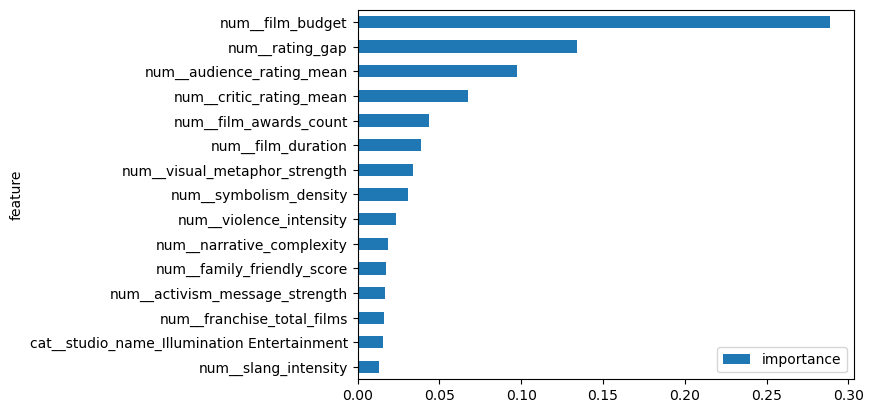

In [ ]:
imp_df.sort_values('importance', ascending=True).tail(15).plot.barh(x='feature', y='importance')
plt.show()


In [ ]:
res['genre'] = X_te['genre'].values  # varsa
res.groupby('genre')['err'].mean().sort_values()


C:\Users\user\AppData\Local\Temp\ipykernel_43472\2523247997.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  res.groupby('genre')['err'].mean().sort_values()


genre
Action|Sci-Fi|Thriller       -1.133669e+08
Drama|Romance                -1.114878e+08
Animation|Adventure|Family   -9.468136e+07
Adventure|Comedy|Family      -5.600838e+07
Action|Thriller              -4.589218e+07
Action|Adventure|Thriller    -3.209780e+07
Action|Adventure|Comedy      -1.416825e+07
Adventure|Drama|Fantasy       1.402041e+07
Other                         1.684924e+07
Action|Adventure              2.030198e+07
Animation|Comedy|Family       3.606845e+07
Comedy|Romance                3.939730e+07
Animation|Adventure|Comedy    9.836301e+07
Action|Adventure|Fantasy      9.866603e+07
Action|Adventure|Sci-Fi       2.222509e+08
Adventure|Fantasy             2.575618e+08
Action|Adventure|Drama                 NaN
Action|Drama|Sci-Fi                    NaN
Action|Drama|War                       NaN
Action|Sci-Fi                          NaN
Adventure|Family|Fantasy               NaN
Animation|Action|Adventure             NaN
Name: err, dtype: float64

In [ ]:
# 1.1 ROI ve bütçe oranları
df_model['roi'] = df_model['film_box_office'] / df_model['film_budget']
df_model['budget_per_minute'] = df_model['film_budget'] / df_model['film_duration']

# 1.2 Rating farkı
df_model['rating_balance'] = df_model['critic_rating_mean'] - df_model['audience_rating_mean']

# 1.3 Sembolik yoğunluk göstergesi
df_model['symbolic_score'] = (
    df_model['visual_metaphor_strength'].fillna(0) + 
    df_model['symbolism_density'].fillna(0)
)

# 1.4 Ödül yoğunluğu (franchise bazlı)
df_model['award_intensity'] = df_model['film_awards_count'] / (df_model['franchise_total_films'] + 1)

# 1.5 Blockbuster bayrağı (bütçe üst çeyreği)
q75 = df_model['film_budget'].quantile(0.75)
df_model['is_blockbuster'] = (df_model['film_budget'] >= q75).astype(int)

# 1.6 Aile ve şiddet dengesine dayalı ton göstergesi
df_model['family_vs_violence'] = (
    df_model['family_friendly_score'].fillna(0) - df_model['violence_intensity'].fillna(0)
)


In [ ]:
X = df_model.drop(columns=['film_box_office'])
y = df_model['film_box_office']


In [ ]:
# Ayrım
X = df_model.drop(columns=['film_box_office'])
y = df_model['film_box_office']

# Tür belirleme
num_cols = X.select_dtypes(include=['int64','float64']).columns.tolist()
cat_cols = X.select_dtypes(include=['object','category','bool']).columns.tolist()

# Ön işleme
pre = ColumnTransformer([
    ('num', Pipeline([
        ('imp', SimpleImputer(strategy='median')),
        ('sc', StandardScaler())
    ]), num_cols),
    ('cat', Pipeline([
        ('imp', SimpleImputer(strategy='most_frequent')),
        ('ohe', OneHotEncoder(drop='first', handle_unknown='ignore'))
    ]), cat_cols)
])

# Train/test
X_tr, X_te, y_tr, y_te = train_test_split(X, y, test_size=0.2, random_state=42)

# Model
rf_new = Pipeline([
    ('prep', pre),
    ('mdl', RandomForestRegressor(n_estimators=400, random_state=42))
])

rf_new.fit(X_tr, y_tr)
y_pred = rf_new.predict(X_te)


In [ ]:
rmse = np.sqrt(mean_squared_error(y_te, y_pred))
mae  = mean_absolute_error(y_te, y_pred)
r2   = r2_score(y_te, y_pred)

print("RMSE:", round(rmse,2))
print("MAE :", round(mae,2))
print("R²  :", round(r2,3))


RMSE: 165353139.74
MAE : 85545726.28
R²  : 0.837


In [ ]:
import pandas as pd
feat = rf_new.named_steps['mdl'].feature_importances_
names = rf_new.named_steps['prep'].get_feature_names_out()
pd.DataFrame({'feature':names,'importance':feat}).sort_values('importance',ascending=False).head(15)


,feature,importance
17,num__roi,0.439204
0,num__film_budget,0.319945
1,num__film_duration,0.034966
18,num__budget_per_minute,0.032156
5,num__rating_gap,0.023442
19,num__rating_balance,0.021199
23,num__family_vs_violence,0.015033
4,num__critic_rating_mean,0.014833
3,num__audience_rating_mean,0.012777
2,num__film_awards_count,0.009291


In [ ]:
import joblib
joblib.dump(rf_new, 'film_success_model_v2.joblib')


['film_success_model_v2.joblib']

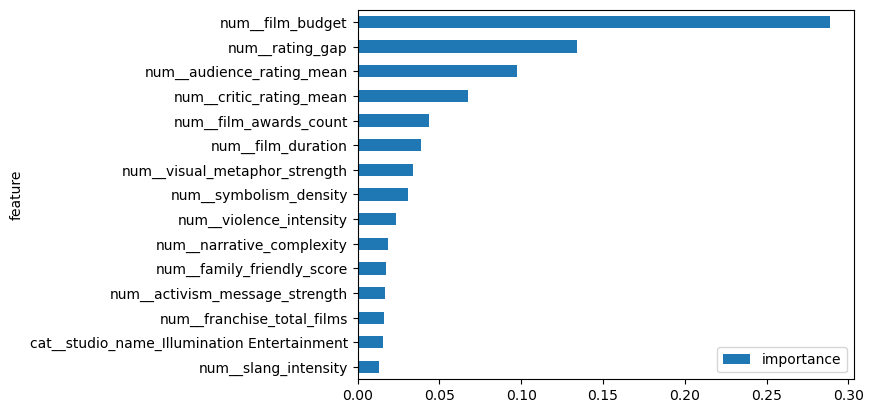

In [ ]:
imp_df.sort_values('importance', ascending=True).tail(15).plot.barh(x='feature', y='importance')
plt.show()

In [ ]:
# Tahmin ve hata
y_pred = rf_new.predict(X_te)
res = pd.DataFrame({
    'y': y_te,
    'pred': y_pred
})
res['err'] = res['y'] - res['pred']

# Genel hata istatistikleri
print(res.describe()[['y','pred','err']])

# Segment bazlı analiz
if 'genre' in X_te.columns:
    seg = X_te['genre']
elif 'film_country' in X_te.columns:
    seg = X_te['film_country']
else:
    seg = None

if seg is not None:
    seg_err = res.groupby(seg)['err'].mean().sort_values()
    print(seg_err)


                  y          pred           err
count  1.000000e+02  1.000000e+02  1.000000e+02
mean   6.668436e+08  6.415095e+08  2.533414e+07
std    4.112719e+08  2.947135e+08  1.642240e+08
min    3.425000e+08  3.785381e+08 -2.418587e+08
25%    3.897000e+08  4.320483e+08 -3.930842e+07
50%    4.847988e+08  5.160923e+08 -1.423721e+07
75%    8.777991e+08  7.892914e+08  3.464454e+07
max    2.923706e+09  1.836517e+09  1.139996e+09
genre
Drama|Romance                -1.344575e+08
Adventure|Comedy|Family      -4.514931e+07
Animation|Adventure|Family   -4.310918e+07
Action|Sci-Fi|Thriller       -2.543805e+07
Adventure|Drama|Fantasy      -2.509370e+07
Action|Adventure|Thriller    -2.084923e+07
Action|Adventure|Comedy      -1.600904e+07
Other                        -1.265718e+07
Animation|Comedy|Family      -2.072624e+06
Action|Thriller               3.976657e+06
Action|Adventure|Fantasy      8.262627e+06
Action|Adventure              1.053386e+07
Comedy|Romance                1.431969e+07
Ani

C:\Users\user\AppData\Local\Temp\ipykernel_43472\1784671983.py:21: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  seg_err = res.groupby(seg)['err'].mean().sort_values()


In [ ]:
pg_cols = ['film_id','family_friendly_score','violence_intensity','sexual_content_intensity']
df_pg = df_parents_guide[[c for c in pg_cols if c in df_parents_guide.columns]].drop_duplicates('film_id')

# Aynı isimli eski sütunlar varsa temizle
df_main = df_main.drop(columns=[c for c in pg_cols if c in df_main.columns and c!='film_id'], errors='ignore')

df_main = df_main.merge(df_pg, on='film_id', how='left')

selected_columns = [
    'film_id',
    'film_budget','film_duration','film_country','film_language',
    'film_awards_count','genre','studio_name',
    'audience_rating_mean','critic_rating_mean','rating_gap',
    'symbolism_density','visual_metaphor_strength',
    'slang_intensity','family_friendly_score','violence_intensity',
    'is_sequel','franchise_total_films','release_season',
    'holiday_release','activism_message_strength','controversy_level',
    'main_theme','narrative_complexity','film_box_office',
    'sexual_content_intensity'  # yeni eklendi
]
df_model = df_main[[c for c in selected_columns if c in df_main.columns]].copy()

# Content risk ve diğer türevler




In [ ]:
df_model['international_factor'] = (df_model['film_country'] != 'USA').astype(int)
df_model['content_risk_index'] = (
    df_model['violence_intensity'].fillna(0) +
    df_model.get('sexual_content_intensity', 0).fillna(0) -
    df_model['family_friendly_score'].fillna(0)
)
df_model['critical_appeal'] = (
    df_model['critic_rating_mean'].fillna(0) + 
    df_model['film_awards_count'].fillna(0)
)
df_model['audience_gap_ratio'] = (
    df_model['rating_gap'] / (df_model['audience_rating_mean'] + 1e-6)
)
df_model['family_target_flag'] = (
    (df_model['family_friendly_score'] > df_model['violence_intensity'])
).astype(int)
df_model[['international_factor','content_risk_index',
          'critical_appeal','audience_gap_ratio','family_target_flag']].info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 5 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   international_factor  500 non-null    int64  
 1   content_risk_index    500 non-null    float64
 2   critical_appeal       500 non-null    float64
 3   audience_gap_ratio    479 non-null    float64
 4   family_target_flag    500 non-null    int64  
dtypes: float64(3), int64(2)
memory usage: 19.7 KB


In [ ]:
# Sadece audience_gap_ratio NaN: 21 adet
agr_med = df_model['audience_gap_ratio'].median()
df_model['audience_gap_ratio'] = df_model['audience_gap_ratio'].fillna(agr_med)

X = df_model.drop(columns=['film_box_office','film_id'])
y = df_model['film_box_office']
X_tr, X_te, y_tr, y_te = train_test_split(X, y, test_size=0.2, random_state=42)

# Train'den stüdyo/genre ortalamaları
studio_mean = y_tr.groupby(X_tr['studio_name']).mean()
genre_mean  = y_tr.groupby(X_tr['genre']).mean()
global_mean = y_tr.mean()

# Map train
X_tr['studio_popularity_score'] = X_tr['studio_name'].map(studio_mean).fillna(global_mean)
X_tr['genre_success_score']     = X_tr['genre'].map(genre_mean).fillna(global_mean)

# Map test (sadece train'de görülen kategorilerle)
X_te['studio_popularity_score'] = X_te['studio_name'].map(studio_mean).fillna(global_mean)
X_te['genre_success_score']     = X_te['genre'].map(genre_mean).fillna(global_mean)

num_cols = X_tr.select_dtypes(include=['int64','float64']).columns.tolist()
cat_cols = X_tr.select_dtypes(include=['object','category','bool']).columns.tolist()

pre = ColumnTransformer([
    ('num', Pipeline([('imp', SimpleImputer(strategy='median')),
                      ('sc', StandardScaler())]), num_cols),
    ('cat', Pipeline([('imp', SimpleImputer(strategy='most_frequent')),
                      ('ohe', OneHotEncoder(drop='first', handle_unknown='ignore'))]), cat_cols)
])

rf = Pipeline([('prep', pre),
               ('mdl', RandomForestRegressor(n_estimators=500, random_state=42))])

rf.fit(X_tr, y_tr)
pred = rf.predict(X_te)

rmse = np.sqrt(mean_squared_error(y_te, pred))
mae  = mean_absolute_error(y_te, pred)
r2   = r2_score(y_te, pred)
print(rmse, mae, r2)


320244892.4956572 198994977.19032004 0.38754932565856715


c:\Users\user\anaconda3\Lib\site-packages\sklearn\preprocessing\_encoders.py:246: UserWarning: Found unknown categories in columns [0, 2, 3, 7] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


In [125]:
from sklearn.experimental import enable_hist_gradient_boosting  # noqa
from sklearn.ensemble import HistGradientBoostingRegressor

# hedefi logla
y_log = np.log1p(y)

X_tr, X_te, y_tr, y_te = train_test_split(X, y_log, test_size=0.2, random_state=42)

num_cols = X_tr.select_dtypes(include=['int64','float64']).columns.tolist()
cat_cols = X_tr.select_dtypes(include=['object','category','bool']).columns.tolist()

ohe = OneHotEncoder(drop='first', handle_unknown='ignore', sparse_output=False)  # sklearn<=1.1
# ohe = OneHotEncoder(drop='first', handle_unknown='ignore', sparse_output=False)  # sklearn>=1.2

pre = ColumnTransformer([
    ('num', Pipeline([('imp', SimpleImputer(strategy='median')),
                      ('sc', StandardScaler())]), num_cols),
    ('cat', Pipeline([('imp', SimpleImputer(strategy='most_frequent')),
                      ('ohe', ohe)]), cat_cols)
])

model = Pipeline([
    ('prep', pre),
    ('mdl', HistGradientBoostingRegressor(
        max_depth=6, learning_rate=0.06, max_iter=700, l2_regularization=0.0,
        early_stopping=True, random_state=42
    ))
])

model.fit(X_tr, y_tr)
pred_log = model.predict(X_te)
pred = np.expm1(pred_log)          # geri dönüştür
y_true = np.expm1(y_te)

rmse = np.sqrt(mean_squared_error(y_true, pred))
mae  = mean_absolute_error(y_true, pred)
r2   = r2_score(y_true, pred)
print(rmse, mae, r2)


317884494.7055061 198912895.7799703 0.3965443146827935


c:\Users\user\anaconda3\Lib\site-packages\sklearn\preprocessing\_encoders.py:246: UserWarning: Found unknown categories in columns [0, 2, 3, 7] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


In [126]:
import pandas as pd

imp = rf.named_steps['mdl'].feature_importances_
names = rf.named_steps['prep'].get_feature_names_out()
imp_df = pd.DataFrame({'feature': names, 'importance': imp}).sort_values('importance', ascending=False)
imp_df.head(20)


,feature,importance
0,num__film_budget,0.237653
22,num__genre_success_score,0.115833
18,num__critical_appeal,0.088686
21,num__studio_popularity_score,0.080428
19,num__audience_gap_ratio,0.079741
1,num__film_duration,0.064248
3,num__audience_rating_mean,0.054278
4,num__critic_rating_mean,0.028288
5,num__rating_gap,0.026396
2,num__film_awards_count,0.023466
